Measure the inference time of a separate detector and recognition network.

In [1]:
import pandas as pd
import torch


def get_sku_mean_width_heights():
    df = pd.read_pickle('../../.cache/sku110_train.pkl')
    im_width_mean = df['width'].mean()
    im_height_mean = df['height'].mean()

    all_boxes = torch.cat([t['boxes'] for t in df['target']])
    all_box_widths = all_boxes[:, ::2].diff().float()
    all_box_heights = all_boxes[:, 1::2].diff().float()
    box_width_mean = float(all_box_widths.mean())
    box_height_mean = float(all_box_heights.mean())

    return (
        im_width_mean, im_height_mean,
        box_width_mean, box_height_mean
    )


def get_sku_num_boxes_per_img():
    df = pd.read_pickle('../../.cache/sku110_train.pkl')
    return torch.tensor([len(t['boxes']) for t in df['target']]).float()


def random_tfm_crop_boxes(
    orig_im_width, orig_im_height,
    orig_box_width, orig_box_height,
    tfm_im_width, tfm_im_height,
    num_boxes
):
    tfm_x_scale = tfm_im_width / orig_im_width
    tfm_y_scale = tfm_im_height / orig_im_height

    tfm_box_width = int(orig_box_width * tfm_x_scale)
    tfm_box_height = int(orig_box_height * tfm_y_scale)

    crop_boxes_x1 = torch.randint(tfm_im_width - tfm_box_width, (num_boxes, 1))
    crop_boxes_y1 = torch.randint(tfm_im_height - tfm_box_height, (num_boxes, 1))

    return torch.hstack([
        crop_boxes_x1,
        crop_boxes_y1,
        crop_boxes_x1 + tfm_box_width,
        crop_boxes_y1 + tfm_box_height,
    ])

In [2]:
from time import time
import torch
from torchvision.transforms import functional as F


def time_separate_det_recog_nets(
    faster_rcnn, rn50,
    device,
    det_input_size,
    recog_input_size,
    dets_per_img,
):
    faster_rcnn.to(device)
    rn50.to(device)
    x = torch.randn((1, 3, det_input_size, det_input_size)).to(device)

    # Output from get_sku_mean_width_heights()
    im_width_mean = 2435.999269628728
    im_height_mean = 3211.501643335362
    box_width_mean = 120.7902603149414
    box_height_mean = 190.1041259765625

    crop_boxes = random_tfm_crop_boxes(
        im_width_mean, im_height_mean,
        box_width_mean, box_height_mean,
        det_input_size, det_input_size,
        dets_per_img
    )

    start = time()

    with torch.no_grad():
        faster_rcnn(x)

    crops = torch.cat([
        F.center_crop(
            F.resize(
                F.crop(x, top=box[1], left=box[0],
                       height=box[3] - box[1], width=box[2] - box[0]),
                recog_input_size
            ),
            recog_input_size
        )
        for box in crop_boxes
    ])

    with torch.no_grad():
        rn50(crops)

    end = time()

    return end - start


def time_joint_det_recog(
    faster_rcnn, recog_head, device,
    det_input_size,
    dets_per_img,
):
    faster_rcnn.to(device)
    recog_head.to(device)
    x = torch.randn((1, 3, det_input_size, det_input_size)).to(device)
    features = torch.randn((faster_rcnn.rpn.post_nms_top_n(),
                            recog_head.in_features)).to(device)

    start = time()

    with torch.no_grad():
        out = faster_rcnn(x)
        recog_head(features)

    end = time()

    return end - start

In [3]:
from tqdm.notebook import tqdm
from itertools import product
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.resnet import resnet50
from random import shuffle


def get_timing_results(
    faster_rcnn,
    rn50,
    recog_head,
    devices,
    det_input_sizes,
    recog_input_sizes,
    dets_per_imgs,
    iters
):
    results = []

    iter_list = list(product(
        det_input_sizes,
        recog_input_sizes,
        dets_per_imgs
    ))

    for device in tqdm(devices):
        for _ in tqdm(range(iters), leave=False):
            # Shuffle to avoid that a certain combination of params
            # always occurs at the same iteration.
            shuffle(iter_list)

            for (det_input_size,
                 recog_input_size,
                 dets_per_img) in tqdm(iter_list, leave=False):
                t_sep = time_separate_det_recog_nets(
                    faster_rcnn, rn50, device,
                    det_input_size=det_input_size,
                    recog_input_size=recog_input_size,
                    dets_per_img=dets_per_img,
                )
                t_joint = time_joint_det_recog(
                    faster_rcnn, recog_head, device,
                    det_input_size=det_input_size,
                    dets_per_img=dets_per_img,
                )
                for t, is_joint in [(t_joint, True),
                                    (t_sep, False)]:
                    results.append({
                        'time': t,
                        'type': 'Joint' if is_joint else 'Separate',
                        'det_input_size': det_input_size,
                        'recog_input_size': recog_input_size,
                        'dets_per_img': dets_per_img,
                        'device': device.type,
                    })
    return pd.DataFrame(results)

In [4]:
from pathlib import Path

from torch import nn


LAZY = True

df_res_path = Path('sep_vs_joint_inference_time_results.pkl')

devices = [
    torch.device('cuda'),
    torch.device('cpu')
]
rn50 = resnet50().eval()
faster_rcnn = fasterrcnn_resnet50_fpn(
    rpn_nms_thresh=1.0,
    box_score_thresh=0.0,
    box_nms_thresh=1.0,
).eval()

id_embedding_size = 512
recog_head = nn.Linear(
    faster_rcnn.roi_heads.box_predictor.cls_score.in_features,
    id_embedding_size
).eval()

In [5]:
if not df_res_path.exists() or not LAZY:
    df_res = get_timing_results(
        faster_rcnn, rn50, recog_head, devices=devices,
        det_input_sizes=[800],
        recog_input_sizes=[224],
        dets_per_imgs=list(range(10, 201, 10)),
        iters=5
    )
    df_res.to_pickle(df_res_path)
else:
    df_res = pd.read_pickle(df_res_path)

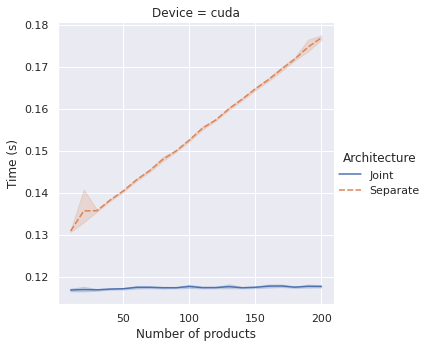

In [6]:
import seaborn as sns
sns.set()

N_PROD = 'Number of products'
TIME = 'Time (s)'
DEVICE = 'Device'
MODEL_TYPE = 'Architecture'

df_res = df_res.rename(columns={
    'dets_per_img': N_PROD,
    'time': TIME,
    'device': DEVICE,
    'type': MODEL_TYPE
})

df_res_cuda = df_res[df_res[DEVICE] == 'cuda']
df_res_cpu = df_res[df_res[DEVICE] == 'cpu']

sns.relplot(data=df_res_cuda,
            x=N_PROD, y=TIME,
            hue=MODEL_TYPE, kind='line', style=MODEL_TYPE, col=DEVICE)

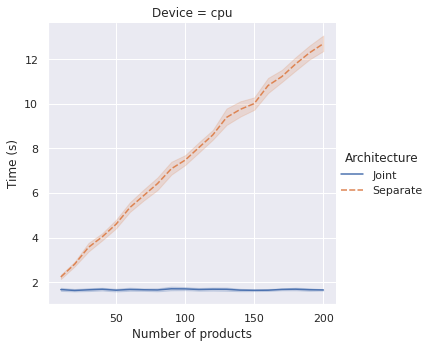

In [7]:
sns.relplot(data=df_res_cpu,
            x=N_PROD, y=TIME,
            hue=MODEL_TYPE, kind='line', style=MODEL_TYPE, col=DEVICE)

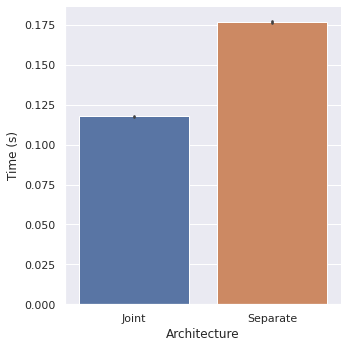

In [8]:
sns.catplot(data=df_res_cuda[df_res_cuda[N_PROD] == 200],
            x=MODEL_TYPE,
            y=TIME, kind="bar")

In [18]:
df_res_cuda[df_res_cuda[N_PROD] == 200].groupby(MODEL_TYPE).mean()

,Time (s),det_input_size,recog_input_size,Number of products
Architecture,,,,
Joint,0.117714,800.0,224.0,200.0
Separate,0.176884,800.0,224.0,200.0


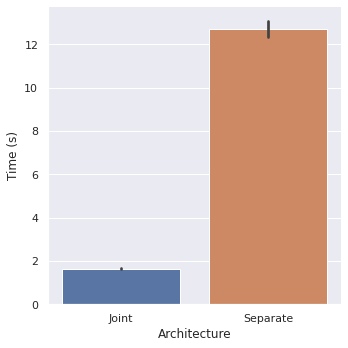

In [9]:
sns.catplot(data=df_res_cpu[df_res_cpu[N_PROD] == 200],
            x=MODEL_TYPE,
            y=TIME, kind="bar")

# Estimated model size of joint vs separate model

In [10]:
def get_model_size_mb(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    return (param_size + buffer_size) / 1024**2

In [14]:
get_model_size_mb(faster_rcnn)

159.68904876708984

In [15]:
get_model_size_mb(rn50)

97.69538116455078

In [16]:
get_model_size_mb(recog_head)

2.001953125

In [11]:
print(f'Estimated joint model size: {get_model_size_mb(faster_rcnn) + get_model_size_mb(recog_head):.1f} MB')

Estimated joint model size: 161.7 MB


In [12]:
print(f'Estimated separate model size: {get_model_size_mb(faster_rcnn) + get_model_size_mb(rn50):.1f} MB')

Estimated separate model size: 257.4 MB


# Linear regression through time vs. number of products

In [13]:
from sklearn.linear_model import LinearRegression

for (t, dev), group in df_res.groupby([MODEL_TYPE, DEVICE]):
    print(f'{t} on {dev}:')
    delay_per_prod = LinearRegression().fit(group[N_PROD].values[:, None], group[TIME]).coef_[0]
    n_prod = 10
    print(f'Delay per extra {n_prod} products: {delay_per_prod*n_prod*1000:.1f} ms\n')

Joint on cpu:
Delay per extra 10 products: 0.1 ms

Joint on cuda:
Delay per extra 10 products: 0.0 ms

Separate on cpu:
Delay per extra 10 products: 552.9 ms

Separate on cuda:
Delay per extra 10 products: 2.4 ms

